In [2]:
import os
import numpy as np
import pandas as pd
import json
import cv2
from PIL import Image
from ipywidgets import interact
import skimage.io as io
from glob import glob
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

import torch
from torchvision import datasets, transforms
from torch.utils.data.dataset import Dataset

from tqdm import tqdm
from time import time


In [3]:
IMG_PATH = "/opt/ml/detection/dataset/"
DATA_IMG_PATH = "/opt/ml/detection/dataset/train"
DATA_JSON_PATH = "/opt/ml/detection/dataset/train.json"
TEST_JSON_PATH = "/opt/ml/detection/dataset/test.json"

In [4]:
with open(DATA_JSON_PATH, 'r') as f:
    json_data = json.load(f)

with open(TEST_JSON_PATH, 'r') as f:
    json_data_test = json.load(f)

category_color = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'deepskyblue', 'purple', 'greenyellow']    

categories = json_data['categories']
annotations = json_data['annotations']
images = json_data['images']

## train.json 구조

In [5]:
for main_key in list(json_data.keys()):
    print(main_key)
    if main_key == 'info':
        for key in list(json_data[main_key].keys()):
            print(f"    |_ {key}")
    else:
        for key in list(json_data[main_key][0].keys()):
            print(f"    |_ {key}")
            if(key == 'bbox'):
                print(f"        |_ xmin")
                print(f"        |_ ymin")
                print(f"        |_ width")
                print(f"        |_ height")


info
    |_ year
    |_ version
    |_ description
    |_ contributor
    |_ url
    |_ date_created
licenses
    |_ id
    |_ name
    |_ url
images
    |_ width
    |_ height
    |_ file_name
    |_ license
    |_ flickr_url
    |_ coco_url
    |_ date_captured
    |_ id
categories
    |_ id
    |_ name
    |_ supercategory
annotations
    |_ image_id
    |_ category_id
    |_ area
    |_ bbox
        |_ xmin
        |_ ymin
        |_ width
        |_ height
    |_ iscrowd
    |_ id


## 쓰레기 종류

In [6]:
# category 별 개수 dicionary 
category_dict = {}
for i in range(len(annotations)):
    cate = categories[annotations[i]['category_id']]['name']
    if cate not in category_dict:
        category_dict[cate] = 1
    else:
        category_dict[cate] += 1
category_count = pd.DataFrame(list(category_dict.items()), columns=['Name', 'Quantity'])

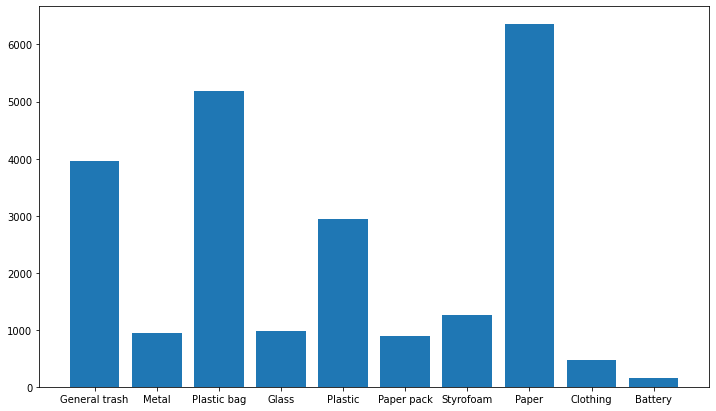

In [7]:
fig, ax = plt.subplots(1, 1, figsize = (12, 7))

ax.bar(
    category_count['Name'],
    category_count['Quantity']
)

plt.show()

쓰레기 카테고리간 불균형이 있음.

## Bounding Box 시각화
from train.json

In [8]:
palette = sns.color_palette('bright')
# 클래스 별로 다른 색 적용

@interact(idx=(0, len(images)-1))
def showImg(idx):
    fig, ax = plt.subplots(1, 1, dpi=150)

    # img_id로부터 파일 이름 생성
    file_name = str(idx)
    file_name = file_name.zfill(4)
    file_name += ".jpg"
    
    # image load
    img = io.imread(os.path.join(DATA_IMG_PATH, file_name))

    # bounding box info load
    bbox_info = []
    for i in range(len(annotations)):
        if (annotations[i]['image_id'] == idx):
            bbox_info.append(annotations[i]['category_id'])
            bbox_info.append(annotations[i]['bbox'])
        elif (annotations[i]['image_id'] > idx):
            break

    ax.imshow(img)
        
    # Create a Rectangle patch
    for i in range(0, len(bbox_info), 2):
        rect = patches.Rectangle(tuple(bbox_info[i+1][0:2]), bbox_info[i+1][2], bbox_info[i+1][3], linewidth=2, edgecolor= category_color[bbox_info[i]], facecolor='none')
        ax.annotate(categories[bbox_info[i]]['name'], [bbox_info[i+1][0]+bbox_info[i+1][2]/2, bbox_info[i+1][1]], bbox=dict(boxstyle='square', color=category_color[bbox_info[i]]))
    
        # Add the patch to the Axes
        ax.add_patch(rect)
        ax.axis('off')

interactive(children=(IntSlider(value=2441, description='idx', max=4882), Output()), _dom_classes=('widget-int…

In [10]:
@interact(category_id=(0, 9))
def showing_trash(category_id):    
    fig, axes = plt.subplots(3, 3, figsize = (20, 20))
    j=0
    for i in range(len(annotations)):
        if annotations[i]['category_id'] == category_id:
            img_id = annotations[i]['image_id']
            bbox = annotations[i]['bbox']
    
            # img_id로부터 파일 이름 생성
            file_name = str(img_id)
            file_name = file_name.zfill(4)
            file_name += ".jpg"
            
            # img load
            im = Image.open(os.path.join(DATA_IMG_PATH, file_name))
            im = im.crop((bbox[0], bbox[1], bbox[0]+bbox[2], bbox[1]+bbox[3]))
            axes[j//3][j%3].imshow(im)
            axes[j//3][j%3].axis('off')
            j += 1
            if (j > 8):
                break
    fig.suptitle(categories[category_id]['name'], fontweight = 'bold')
    plt.show()
        

interactive(children=(IntSlider(value=4, description='category_id', max=9), Output()), _dom_classes=('widget-i…

## Bounding Box 넓이 분포

### 전체 분포

In [11]:
# 각 bounding box의 area list
area_list = []
for i in range(len(annotations)):
    area_list.append([annotations[i]['area'], annotations[i]['category_id']])

'''
area_list1 = [a for a in area_list if a < 10000]
print(len(area_list1)/len(area_list))
print(f"MIN:{min(area_list)}, MAX:{max(area_list)}")'''

area_df = pd.DataFrame(area_list, columns=['Area', 'Category'])

print(area_df)

            Area  Category
0      257301.66         0
1       10402.56         3
2       26259.36         7
3       69096.17         4
4       24164.58         5
...          ...       ...
23139  768591.81         5
23140   57309.72         7
23141    1772.74         0
23142   53008.67         1
23143  149633.22         1

[23144 rows x 2 columns]


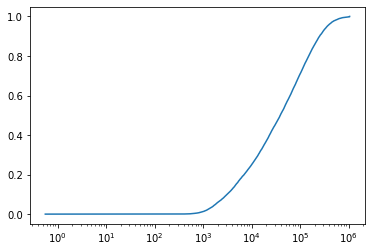

In [13]:
# compute the CDF
a_list = [area_list[i][0] for i in range(len(area_list))]
cdfx = sorted(a_list)
cdfy = np.linspace(1 / len(a_list), 1.0, len(a_list))
# plot the CDF
plt.plot(cdfx, cdfy)
plt.xscale('log')
plt.show()

/opt/conda/envs/detection/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[Text(0, 0, '(0.56, 6990.08)'),
 Text(1, 0, '(6991.08, 23418.57)'),
 Text(2, 0, '(23430.2, 62007.84)'),
 Text(3, 0, '(62041.5, 149517.72)'),
 Text(4, 0, '(149527.84, 1048371.21)')]

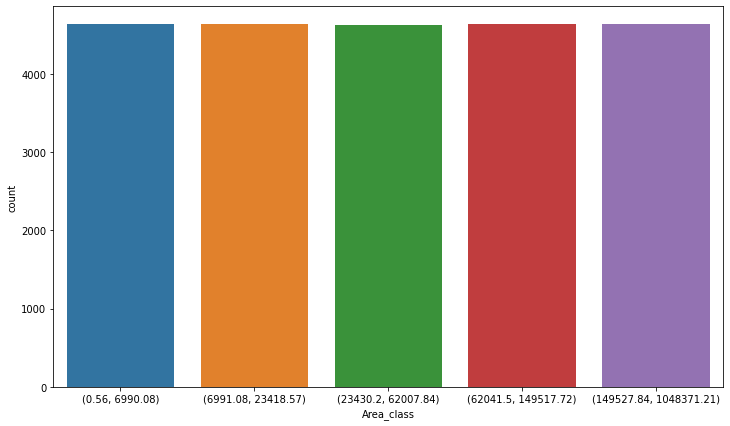

In [14]:
fig, ax = plt.subplots(1, 1, figsize = (12, 7))
area_df['Area_class'] = pd.qcut(area_df['Area'], 5, labels=['A','B','C','D','E'])
maxs = []
mins = []
for a in ['A', 'B','C','D','E']:
    mins.append(area_df['Area'][area_df['Area_class'] == a].min())
    maxs.append(area_df['Area'][area_df['Area_class'] == a].max())

sns.countplot(
    area_df['Area_class']
)
ax.set_xticklabels(list(zip(mins, maxs)))

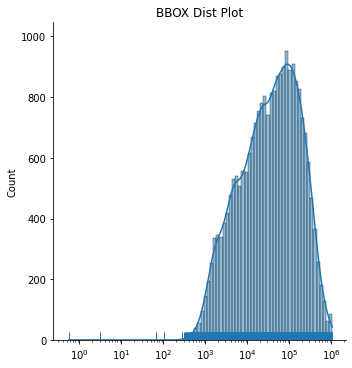

In [16]:
sns.displot(a_list, kde=True, rug=True, log_scale=True)
plt.title("BBOX Dist Plot")
#plt.xscale('log')
plt.show()

bounding box가 아주 작은 것, 아주 큰 것도 별로 없다.

### 클래스 별 넓이 분포

In [17]:
@interact(category_id = (0, 9))
def showing_area_distribution(category_id):
    target_df = area_df[area_df['Category'] == category_id]
    sns.displot(target_df['Area'], kde=True, rug=True, log_scale=True)
    plt.title(f"BBOX Dist Plot {categories[category_id]['name']}")

interactive(children=(IntSlider(value=4, description='category_id', max=9), Output()), _dom_classes=('widget-i…

Text(0.5, 1.0, 'BBOX Dist Plot')

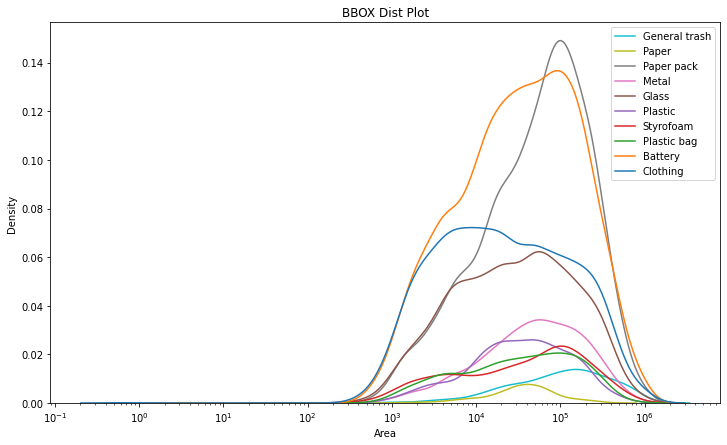

In [20]:
fig, ax = plt.subplots(1, 1, figsize = (12, 7))
sns.kdeplot(area_df['Area'], hue = area_df['Category'], log_scale=True, ax = ax, palette='tab10')
plt.legend([categories[i]['name'] for i in range(10)])
plt.title(f"BBOX Dist Plot")

## 이미지 데이터세트에 대한 평균(mean)과 표준편차(std)

In [91]:
N_CHANNELS = 3

# img file name
img_file_names = [json_data['images'][i]['file_name'] for i in range(0, 4883)]
for i in range(4871):
    img_file_names.append(json_data_test['images'][i]['file_name'])
'''
before = time()
mean = torch.zeros(1)
std = torch.zeros(1)
print('==> Computing mean and std..')
for inputs, _labels in tqdm(full_loader):
    for i in range(N_CHANNELS):
        mean[i] += inputs[:,i,:,:].mean()
        std[i] += inputs[:,i,:,:].std()
mean.div_(len(dataset)) 
td.div_(len(dataset))
print(mean, std)
print("time elapsed: ", time()-before)'''

img_norm1 = list()
img_norm2 = list()
img_std1 = list()
img_std2 = list()

for file_name in tqdm(img_file_names):
    img_path = os.path.join(IMG_PATH, file_name)
    img = cv2.imread(img_path, cv2.IMREAD_COLOR).astype(np.float32)/255.0
    mean,std = np.mean(img, axis=(0,1)), np.std(img, axis=(0,1))
    img_norm1.append(mean)
    img_std1.append(std)

print(np.mean(img_norm, axis=0), np.mean(img_std, axis=0))

100%|██████████| 9754/9754 [20:59<00:00,  7.74it/s]

[0.43122166 0.45993936 0.4841715 ] [0.21523651 0.20979142 0.21214761]


In [96]:
print('mean: ', np.mean(img_norm, axis=0) * 255, '\nstd: ', np.mean(img_std, axis=0) * 255)
print("coco: mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375]")
print(np.mean(img_norm, axis=0), np.mean(img_std, axis=0))

mean:  [109.961525 117.28454  123.46374 ] 
std:  [54.88531 53.49681 54.09764]
coco: mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375]
[0.43122166 0.45993936 0.4841715 ] [0.21523651 0.20979142 0.21214761]
